Avaliação da base de dados IMDB PT-BR disponível em: kaggle.com/luisfredgs/imdb-ptbr
Análise de sentimentos para a classificação dos filmes, se foram considerados negativos ou positivos, de acordo com a avaliação 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nltk

# O Nltk é uma biblioteca que disponibiliza alguns conjuntos de texto chamados de corpus

In [2]:
filme = pd.read_csv('imdb-reviews-pt-br.csv')
filme.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [3]:
# Cria nova coluna para classificar a nota como 0 = neg e 1 = pos
nota = filme["sentiment"].replace(["neg", "pos"], [0,1])
filme["nota"] = nota
filme.head()

,id,text_en,text_pt,sentiment,nota
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [4]:
filme.tail()

,id,text_en,text_pt,sentiment,nota
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,1
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,1
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,1
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,1
49458,49460,Working-class romantic drama from director Mar...,O drama romântico da classe trabalhadora do di...,pos,1


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# O CountVectorizer é o responsável por fazer a vetorização dos dados de texto e transformá-los em uma matriz de frequência.

In [6]:
# Criando Bag of words (transforma em conjunto de termos e frequencias)
# vetor onde as palavras são as colunas e as linhas são 
# compostas pelo número de vezes que a palavra aparece no texto.


vetor = CountVectorizer(lowercase = False, max_features = 50)
bag = vetor.fit_transform(filme["text_pt"])

In [7]:
print(bag.shape)

(49459, 50)


In [8]:
from sklearn.model_selection import train_test_split

treino, teste, classe_treino, classe_teste = train_test_split(bag, filme["nota"], random_state=42)

In [9]:
# 25% para teste

print(treino.shape)
print(teste.shape)

(37094, 50)
(12365, 50)


In [10]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(solver = "lbfgs")
reg.fit(treino, classe_treino)
previsao = reg.predict_proba(teste)
print(previsao)

[[0.25696739 0.74303261]
 [0.72224991 0.27775009]
 [0.70076066 0.29923934]
 ...
 [0.46019618 0.53980382]
 [0.46166722 0.53833278]
 [0.61777927 0.38222073]]


In [11]:
prev = previsao[:,1] >= 0.5
print(prev)

[ True False False ...  True  True False]


In [12]:
previsao_teste_int = prev.astype(np.int)
print(previsao_teste_int)

[1 0 0 ... 1 1 0]


In [13]:
from sklearn.metrics import accuracy_score

acuracia = accuracy_score(classe_teste, previsao_teste_int)
print(acuracia)

0.6583097452486858


In [14]:
from wordcloud import WordCloud

palavra = ' '.join([texto for texto in filme["text_pt"]])

In [15]:
nuvem_palavras = WordCloud(width = 800, height = 500, max_font_size = 110, collocations = False).generate(palavra)

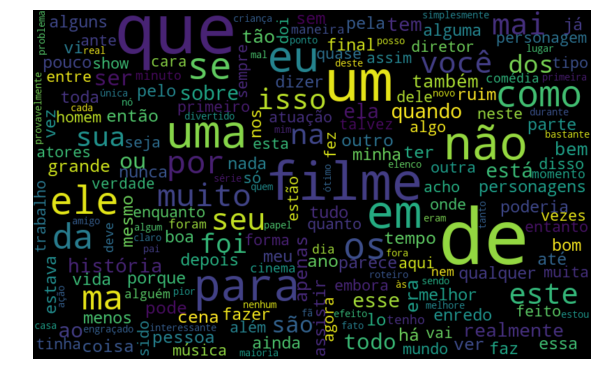

In [16]:
plt.figure(figsize = (10,7))
plt.imshow(nuvem_palavras, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [17]:
# Usando o NLTK
# Retirando os espaços e salvando em um novo Dataset com a frequencia das palavras

from nltk import tokenize

token_espaco = tokenize.WhitespaceTokenizer()
todas_palavras = ' '.join([texto for texto in filme["text_pt"]])
freq = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
df_freq = pd.DataFrame({"Palavra": list(freq.keys()),
                        "Frequência": list(freq.values())})
df_freq.head()

,Palavra,Frequência
0,Mais,1538
1,uma,130888
2,"vez,",1927
3,o,244881
4,Sr.,1741


In [18]:
# 10 palavras com mais frequencia

df_freq = df_freq.nlargest(columns = "Frequência", n = 10)
df_freq

,Palavra,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


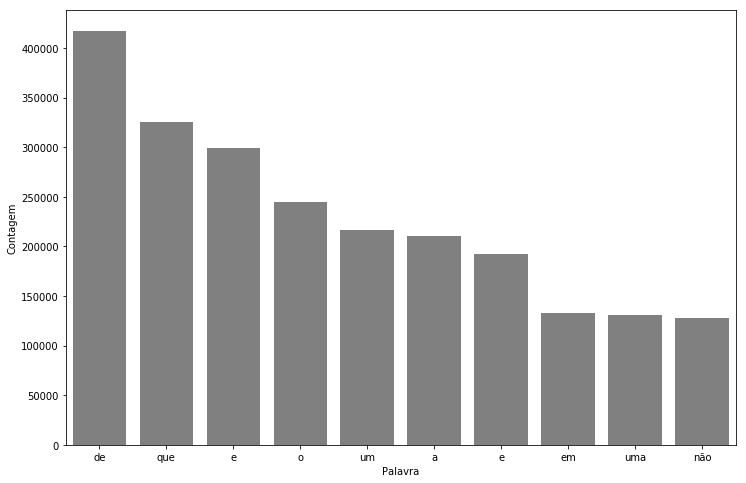

In [19]:
import seaborn as sns

plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_freq, x= "Palavra", y = "Frequência", color = 'gray')
ax.set(ylabel = "Contagem")
plt.show()

In [20]:
# Criando funções
# Retirando as palavras desnecessárias

palavras_desnecessarias = nltk.corpus.stopwords.words("portuguese")
frase_processada = list()

for opiniao in filme["text_pt"]:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_desnecessarias:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
filme["tratamento_1"] = frase_processada

In [21]:
filme.head()

,id,text_en,text_pt,sentiment,nota,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


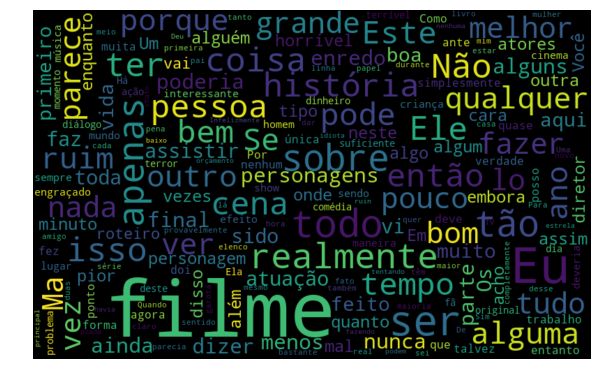

In [22]:
# Nuvem de palavras negativas

def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'neg'")
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])
    nuvem_palavras = WordCloud(width = 800, height = 500,
                                max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
nuvem_palavras_neg(filme, "tratamento_1")

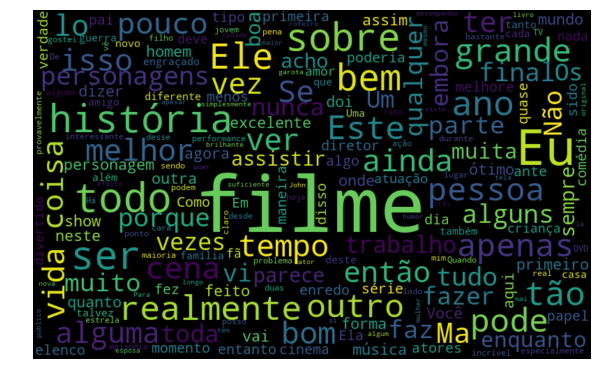

In [23]:
# Nuvem de palavras positivas

def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("sentiment == 'pos'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])
    nuvem_palavras = WordCloud(width = 800, height = 500,
                                max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
nuvem_palavras_pos(filme, "tratamento_1")

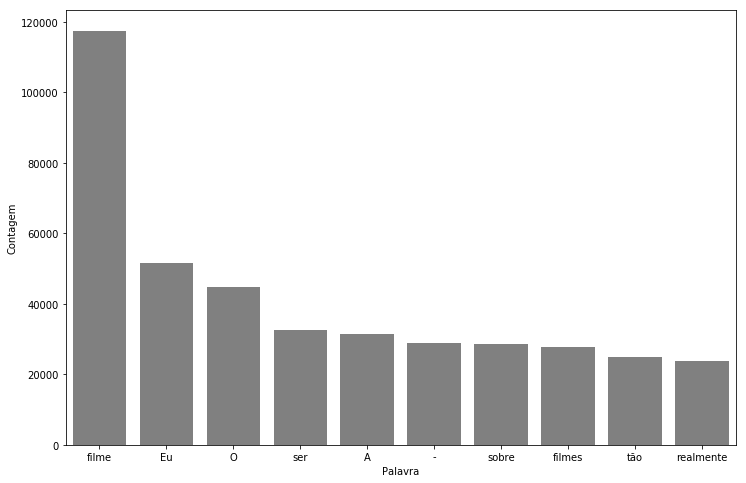

In [24]:
# Função para gerar gráfico de barras com o quantitativo de palavras

def barra(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()   

barra(filme, "tratamento_1", 10)

In [25]:
# Função para classificar o texto

def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                 texto[coluna_classificacao],
                                                                 random_state = 42)
    
    regressao_logistica = LogisticRegression(solver="lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    
    return regressao_logistica.score(teste, classe_teste)

acuracia_teste = classificar_texto(filme, "tratamento_1", "nota")
print(acuracia_teste)

0.6607359482410028


In [26]:
# Melhorando a visualização

token_pontuacao = tokenize.WordPunctTokenizer()

from string import punctuation

pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_desnecessarias

frase_processada = list()
for opiniao in filme["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
filme["tratamento_2"] = frase_processada

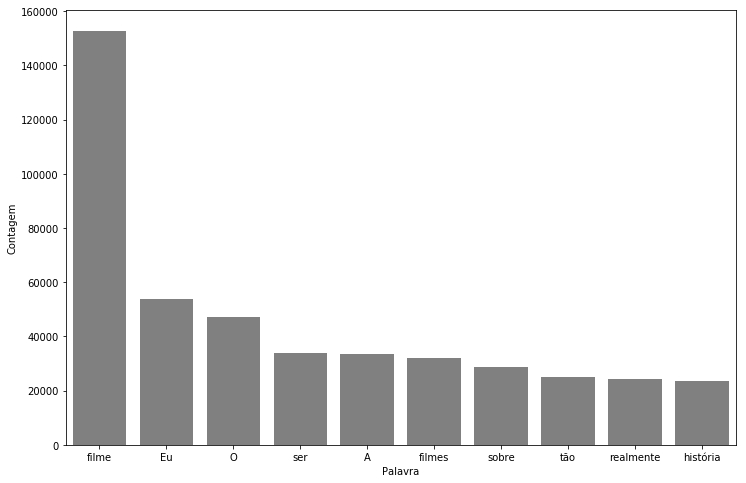

In [27]:
barra(filme, "tratamento_2", 10)

In [28]:
# Normalizando o texto

import unidecode

sem_acentos = [unidecode.unidecode(texto) for texto in filme["tratamento_2"]]

stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

In [29]:
filme["tratamento_3"] = sem_acentos

# Tirando os acentos e pontuação

frase_processada = list()
for opiniao in filme["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
filme["tratamento_3"] = frase_processada

In [30]:
# Primeira acurácia
print(acuracia_teste)


# Acurácia com tratamentos
acuracia_tratamento3 = classificar_texto(filme, "tratamento_3", "nota")
print(acuracia_tratamento3)

0.6607359482410028
0.6879094217549535


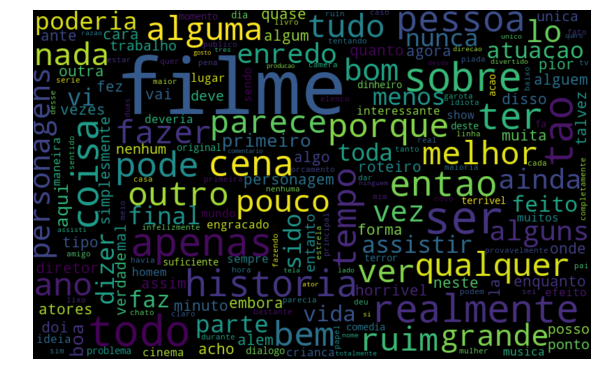

In [31]:
# Nuvem de palavras negativas com tratamentos

nuvem_palavras_neg(filme, "tratamento_3")

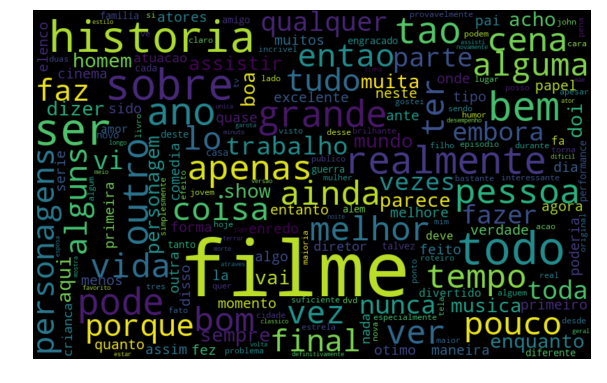

In [32]:
# Nuvem de palavras positiva com tratamentos

nuvem_palavras_pos(filme, "tratamento_3")

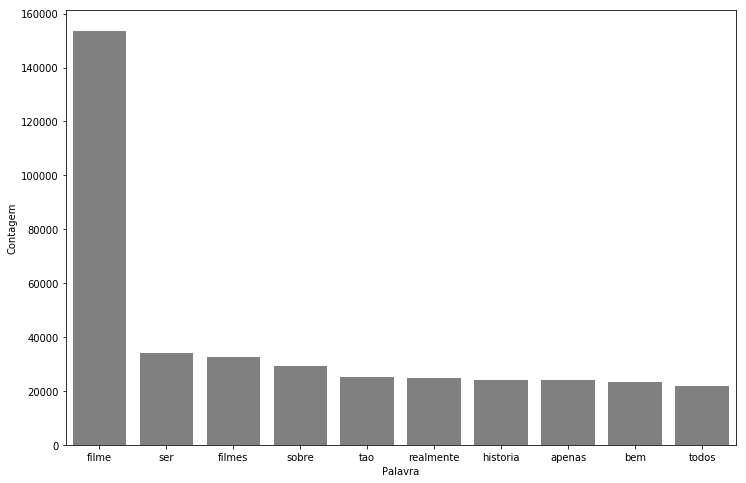

In [33]:
# Gráfico de barras com as palavras tratadas

barra(filme, "tratamento_3", 10)

In [35]:
# Retirando as derivações nas palavras


stemmer = nltk.RSLPStemmer()

frase_processada = list()
for opiniao in filme["tratamento_3"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))
    
filme["tratamento_4"] = frase_processada

In [36]:
# Avaliando a acurácia com o tratamento4 em relação ao tratamento3

acuracia_tratamento4 = classificar_texto(filme, "tratamento_4", "nota")
print(acuracia_tratamento3)
print(acuracia_tratamento4)

0.6879094217549535
0.6943792964011323


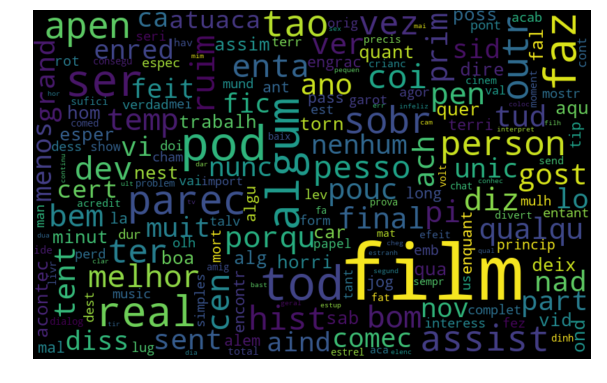

In [37]:
nuvem_palavras_neg(filme, "tratamento_4")

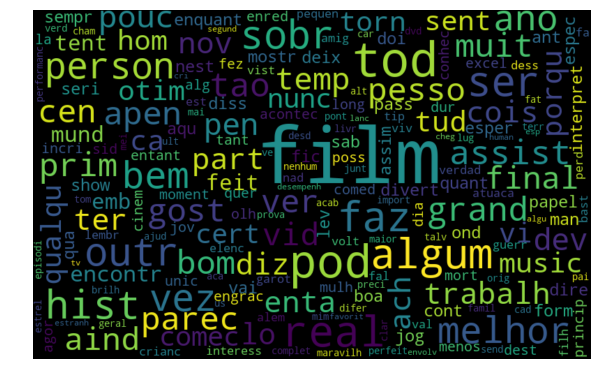

In [39]:
nuvem_palavras_pos(filme,"tratamento_4")

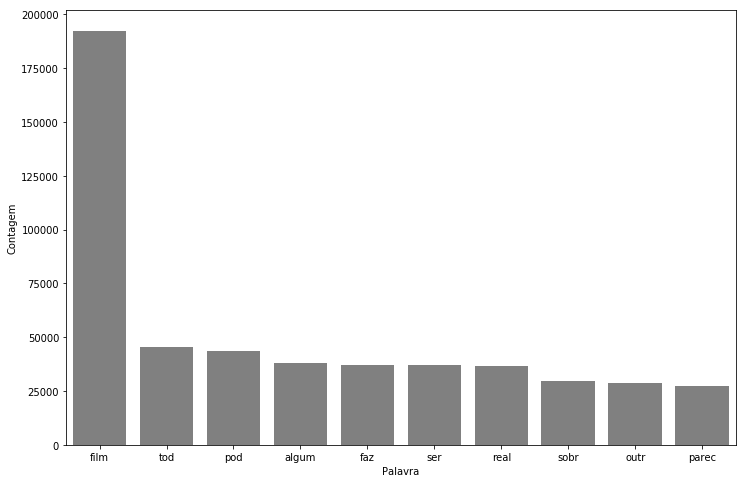

In [42]:
barra(filme, "tratamento_4", 10)